#**Machine Learning for Digital Fraud Detection**
###Comparing the Performance of Stacking Classifier & Deep Learning Models in Identifying Instances of Digital Transaction Fraud



Brian Morrison

DATA606 - Capstone Project in Data Science

Professor Jay Wang

The University of Maryland, Baltimore County

##**Part One - EDA & Dataset Preparation**

####**Introduction & Notebook Overview**

The purpose of this notebook is to 

* Fetch source data files from the project's Github repository, stored in Data/Source
* Combine, clean, and analyze the data
* Trim unwanted features through feature importance identification and dimensionality reduction
* Complete final preparations to feed to machine learning models, including encoding of categorical variables

Throughout the notebook, changes will be made to align data parameters with machine learning models - more specifically, changes will largely be oriented towards gradient or distance-based models that may be sensitive to differences in the magnitude of variances in features. For example, a distance-based classifier may interpret differences in transaction amounts as more meaningful than differences in number of transactions made by cards due to large discrepancies in purchase amounts, despite the assumption in training that all features should be considered equally.

Thus, the desired outcome from this notebook is a dataset that contains only integer columns with no null values, and whose column ranges are scaled to be approximately (0, 1). 

####**Importing Data**

In [ ]:
#we'll start by reading in the dataset, which is stored as multiple csv files in this project's github repository

import numpy as np
import pandas as pd

df_dict = {} #instantiating blank dictionary to store dataframes
df_list = ['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7']

for df in df_list:
  df_url = 'https://raw.githubusercontent.com/briancmorrison/brian_data606/main/Data/Source/' + df + '.csv' #transaction data url formats
  df_name = 'transaction_df' + df[2]
  df_dict[df_name] = pd.read_csv(df_url, index_col = 0) #add dataframe to dictionary

identity_url = 'https://raw.githubusercontent.com/briancmorrison/brian_data606/main/Data/Source/identity_file.csv' #identity data url format

identity_df = pd.read_csv(identity_url)

In [ ]:
df_dict['transaction_df1'].head() #examining the head of our first transactional dataframe

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
identity_df.head() #examining the head of our first transactional dataframe

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


####**Combining Data**

In [ ]:
#to start, we will concatenate the 7 transactional dataframes, as they were split row-wise in the previous notebook

transactional_df = pd.concat(df_dict.values(), ignore_index = True)
len(transactional_df) #confirming length is equivalent to dataset prior to splitting - 590540

590540

In [ ]:
#next, we will merge the transactional dataframe with the identity dataframe, using a left outer join to preserve all transactions

df_full = transactional_df.merge(identity_df, how = 'left', on = 'TransactionID')
df_full.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
#now, we can check what proportion of transactions are fraudulent - as we will likely want to augment this minority class 

df_full['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

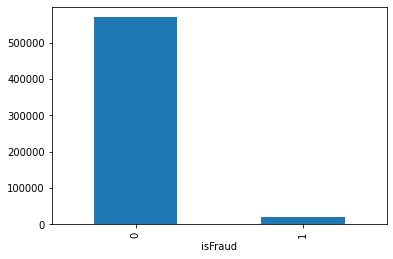

In [ ]:
df_full.pivot_table(index = 'isFraud', aggfunc = 'size').plot(kind = 'bar') #visualizing class imbalance

#Reference link: https://towardsdatascience.com/smote-fdce2f605729

####**Data Cleaning & Feature Selection**

In order to properly explore our data, or those portions of it that will be relevant to our machine learning models, we will first want to trim down extraneous features. Columns with null values, columns that provide little to no meaningful information, and 'tag' columns like Transaction ID and isFraud, will be removed. 

Importantly, the removal of columns containing null values in this project is one primarily based on resource constraints. Other methods for handling the presence of null values in a dataset, such as value imputing or feature combination or engineering, are included in later sections as a promising future direction for this project. For example, leveraging identity information could help to generate novel features such as quantity of transactions made by a particular card in the given timeframe, or amount spent by a particular card, may elicit informative features for the models to consider.

#####Feature Selection

In [ ]:
#to start, let's check how many columns have null values

nulls = df_full.isna().sum() #counting null values in each column

counter = 0

for digit in range(len(nulls)):
  if nulls[digit] > 0:
    counter += 1 #counting all columns with null values

print(counter)

414


In [ ]:
nulls_prop = df_full.isna().sum() / len(df_full) #proportion of nulls to full dataset length

counter = 0

for digit in range(len(nulls_prop)):
  if nulls[digit] < .05: #checking for columns that are less than 5% null vallues
    counter += 1

print(counter)

20


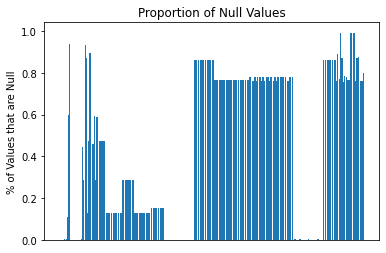

In [ ]:
#visualizing the presence of null values across the dataset

import matplotlib.pyplot as plt

plt.title('Proportion of Null Values')
plt.bar(df_full.columns, nulls_prop.values)
frame = plt.gca()
frame.axes.xaxis.set_ticklabels([]) #removing x axis labels due to text bleeding
frame.axes.get_xaxis().set_visible(False)
plt.ylabel('% of Values that are Null')
plt.show()

In [ ]:
#grabbing a list of columns with no null values

columns_nonulls = []

for digit in range(len(nulls)):
  if nulls[digit] == 0:
    columns_nonulls.append(nulls.index[digit])

print(columns_nonulls)

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']


In [ ]:
#filtering down to the new dataset

df_working = df_full[columns_nonulls]
df_working.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,2987000,0,86400,68.5,W,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,2987001,0,86401,29.0,W,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,2987002,0,86469,59.0,W,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2987003,0,86499,50.0,W,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,2987004,0,86506,50.0,H,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


In [ ]:
#clearing variables to free up space

del df_full
del df_dict
del identity_df

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x) # suppressing scientific notation

df_working.describe() # examining distribution of columns, to consider in later scaling steps

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000
mean,3282269.50000,0.03499,7372311.31012,135.02718,9898.73466,14.09246,15.26973,0.00564,4.09219,5.57153,9.07108,2.84848,5.14457,4.48024,5.24034,10.24152,4.07623,32.53992,8.29521
std,170474.35832,0.18375,4617223.64654,239.16252,4901.17015,133.56902,154.66890,0.15054,68.84846,25.78698,71.50847,61.72730,95.37857,16.67490,95.58144,94.33629,86.66622,129.36484,49.54426
min,2987000.00000,0.00000,86400.00000,0.25100,1000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,3134634.75000,0.00000,3027057.75000,43.32100,6019.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000
50%,3282269.50000,0.00000,7306527.50000,68.76900,9678.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,3.00000,1.00000
75%,3429904.25000,0.00000,11246620.00000,125.00000,14184.00000,3.00000,3.00000,0.00000,0.00000,1.00000,2.00000,0.00000,0.00000,2.00000,0.00000,2.00000,0.00000,12.00000,2.00000
max,3577539.00000,1.00000,15811131.00000,31937.39100,18396.00000,4685.00000,5691.00000,26.00000,2253.00000,349.00000,2253.00000,2255.00000,3331.00000,210.00000,3257.00000,3188.00000,3188.00000,2918.00000,1429.00000


#####Categorical Variable Encoding

In preparing our data to be fed into a machine learning model, we'll now need to convert categorical variables to numeric ones through One Hot Encoding - a process by which unique categories from the feature are "popped" out into separate columns, with binary values indicating whether or not the record is associated with the category. Using [this discussion post](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203) from the original Kaggle competition, we can identify the categorical variables in our dataset as ProductCD and card1, which we will encode now.

In [ ]:
#starting by removing our TransactionID and isFraud variables, as these will not be included in our data cleaning efforts

transaction_ids = df_working.pop('TransactionID')
class_labels = df_working.pop('isFraud')
df_working.head()

,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,86400,68.50000,W,13926,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,2.00000,0.00000,1.00000,1.00000
1,86401,29.00000,W,2755,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000
2,86469,59.00000,W,4663,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000
3,86499,50.00000,W,18132,2.00000,5.00000,0.00000,0.00000,0.00000,4.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,25.00000,1.00000
4,86506,50.00000,H,4497,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000


In [ ]:
#due to Google Colab RAM limitations, I unfortunately needed to drop the card1 variable, which was consuming a significant amount of memory in encoding

df_working = df_working.drop('card1', axis = 1)

In [ ]:
#using pandas get_dummies method, we can now encode our two categorical columns so they are meaningful to our models

df_dumm_PCD = pd.get_dummies(df_working['ProductCD']) # only interested in encoding the categorical column

df_encoded = pd.concat([df_working, df_dumm_PCD], axis = 1) # adding the features extracted from the columns back to our dataframe
df_unscaled = df_encoded.drop('ProductCD', axis = 1) #dropping encoded column

df_unscaled.head()

,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,...,C10,C11,C12,C13,C14,C,H,R,S,W
0,86400,68.50000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,2.00000,0.00000,1.00000,1.00000,0,0,0,0,1
1,86401,29.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,1.00000,1.00000,0,0,0,0,1
2,86469,59.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,1.00000,1.00000,0,0,0,0,1
3,86499,50.00000,2.00000,5.00000,0.00000,0.00000,0.00000,4.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,25.00000,1.00000,0,0,0,0,1
4,86506,50.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,...,1.00000,1.00000,0.00000,1.00000,1.00000,0,1,0,0,0


#####Feature Scaling

We can now move on to scaling data, a requirement for many distance and gradient-based machine learning models. Feature scaling involves standardizing features to a range of approximately (0, 1) and a mean value of approximately 0. This allows equal consideration of features by distance or gradient based models, which might otherwise assume that a larger magnitude of variance in one feature relative to others indicates heightened importance of that feature.

We will use boxplots to visualize the range and approximate percentile distributions of our features to guide scaling.

In [ ]:
df_unscaled.describe(percentiles = [0.01,0.03, 0.05,.1,.25,.5,.75,.9, .99]) # examining distribution to guide scaler selection

,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,...,C10,C11,C12,C13,C14,C,H,R,S,W
count,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,...,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000
mean,7372311.31012,135.02718,14.09246,15.26973,0.00564,4.09219,5.57153,9.07108,2.84848,5.14457,...,5.24034,10.24152,4.07623,32.53992,8.29521,0.11603,0.05592,0.06384,0.01969,0.74452
std,4617223.64654,239.16252,133.56902,154.66890,0.15054,68.84846,25.78698,71.50847,61.72730,95.37857,...,95.58144,94.33629,86.66622,129.36484,49.54426,0.32026,0.22977,0.24446,0.13893,0.43613
min,86400.00000,0.25100,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1%,185058.82000,9.24400,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3%,485287.38000,15.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5%,751946.50000,20.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
10%,1361004.40000,25.95000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,3027057.75000,43.32100,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,7306527.50000,68.76900,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,3.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000


{'boxes': [<matplotlib.lines.Line2D at 0x7efbf36cee10>,
 'caps': [<matplotlib.lines.Line2D at 0x7efbf3820fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efbf36caa50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efbf38018d0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7efbf36ce910>,
  <matplotlib.lines.Line2D at 0x7efbf262bf90>]}

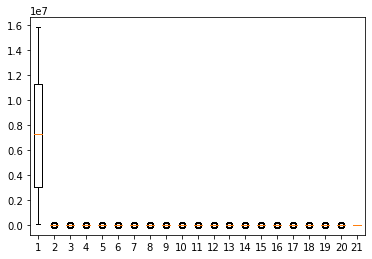

In [ ]:
import matplotlib.pyplot as plt

df_unscaled_np = df_unscaled.to_numpy() # converting dataframe to numpy array
plt.boxplot(df_unscaled_np) # visualizing to provide further insights related to scaler selection

Based on the output of the boxplot above, it's apparent that we need to perform significant scaling on one column in the dataset - column 1, TransactionDT. This column denotes a time feature, so it is reasonable to assume it is normally distributed and does not contain outliers. Standard Scaler should be an effective approach to scaling this feature, but just in case, we'll also test out a MinMax Scaler to see what is most effective.

Given the logarithmic scale generated by this boxplot, we'll need to separately examine the other dataset columns to identify what scaling method may be sensible to use.

{'boxes': [<matplotlib.lines.Line2D at 0x7efbf25326d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7efbf2538690>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efbf25406d0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efbf2540190>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7efbf2532c50>,
  <matplotlib.lines.Line2D at 0x7efbf23aa5d0>]}

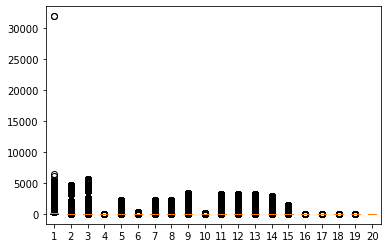

In [ ]:
df_unscaled2_np = df_unscaled.loc[:, df_unscaled.columns != 'TransactionDT'].to_numpy()
plt.boxplot(df_unscaled2_np)

We can start by scaling these columns, trying out a a simple MinMaxScaler to evaluate its effectiveness. Looking at the percentiles chart we previously generated, it's clear that these columns are abnormally distributed with a high prevalence of outliers, and it is therefore unlikely that a simple Standard Scaler would resolve our scaling needs. For this reason, a RobustScaler - which tends to be more receptive to the presense of outliers - was initially tested. However, the disparity between minimum and maximum values appeared to make the MinMaxScaler a better option for our purposes.

{'boxes': [<matplotlib.lines.Line2D at 0x7efbe61c2990>,
 'caps': [<matplotlib.lines.Line2D at 0x7efbe6146a10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efbe614ca50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efbe614c510>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7efbe61c2f50>,
  <matplotlib.lines.Line2D at 0x7efbe60419d0>]}

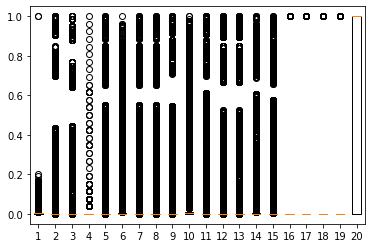

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler

mmscaler = MinMaxScaler()
#rscaler = RobustScaler()

for col in df_unscaled.loc[:, df_unscaled.columns.drop(['TransactionDT', 'C', 'H', 'R', 'S', 'W'])]: #also excluding columns derived from encoding
  df_unscaled[col] = mmscaler.fit_transform(df_unscaled[[col]])

df_unscaled2_np = df_unscaled.loc[:, df_unscaled.columns != 'TransactionDT'].to_numpy()
plt.boxplot(df_unscaled2_np)

In [ ]:
df_unscaled.describe(percentiles = [0.01,0.03, 0.05,.1,.25,.5,.75,.9, .99])

,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,...,C10,C11,C12,C13,C14,C,H,R,S,W
count,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,...,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000,590540.00000
mean,7372311.31012,0.00422,0.00301,0.00268,0.00022,0.00182,0.01596,0.00403,0.00126,0.00154,...,0.00161,0.00321,0.00128,0.01115,0.00580,0.11603,0.05592,0.06384,0.01969,0.74452
std,4617223.64654,0.00749,0.02851,0.02718,0.00579,0.03056,0.07389,0.03174,0.02737,0.02863,...,0.02935,0.02959,0.02719,0.04433,0.03467,0.32026,0.22977,0.24446,0.13893,0.43613
min,86400.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1%,185058.82000,0.00028,0.00021,0.00018,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00031,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3%,485287.38000,0.00046,0.00021,0.00018,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00031,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5%,751946.50000,0.00062,0.00021,0.00018,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00031,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
10%,1361004.40000,0.00080,0.00021,0.00018,0.00000,0.00000,0.00000,0.00044,0.00000,0.00000,...,0.00000,0.00031,0.00000,0.00034,0.00070,0.00000,0.00000,0.00000,0.00000,0.00000
25%,3027057.75000,0.00135,0.00021,0.00018,0.00000,0.00000,0.00000,0.00044,0.00000,0.00000,...,0.00000,0.00031,0.00000,0.00034,0.00070,0.00000,0.00000,0.00000,0.00000,0.00000
50%,7306527.50000,0.00215,0.00021,0.00018,0.00000,0.00000,0.00000,0.00044,0.00000,0.00000,...,0.00000,0.00031,0.00000,0.00103,0.00070,0.00000,0.00000,0.00000,0.00000,1.00000


While still a hectic looking boxplot, it appears our features have been scaled down to ranges of 0 to 1 and means of approximately the same range. For our case, this will be sufficient and we will progress on to scaling our final column - TransactionDT. 

In [ ]:
from sklearn.preprocessing import StandardScaler

column = ['TransactionDT']
sscaler = StandardScaler()

df_unscaled['TransactionDT_sscaler'] = sscaler.fit_transform(df_unscaled[column])

mmscaler = MinMaxScaler()

df_unscaled['TransactionDT_mmscaler'] = mmscaler.fit_transform(df_unscaled[column])

{'boxes': [<matplotlib.lines.Line2D at 0x7efbe5f30fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7efbe5f3d050>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efbe5ec4090>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efbe5f3db10>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7efbe5f37590>,
  <matplotlib.lines.Line2D at 0x7efbe5ecb050>]}

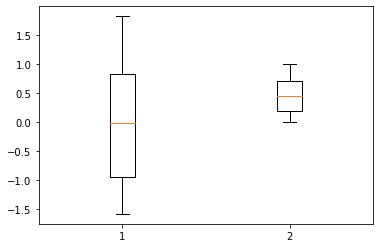

In [ ]:
df_tdt = df_unscaled[['TransactionDT_sscaler', 'TransactionDT_mmscaler']].to_numpy() #regenerating boxplot with only column of interest
plt.boxplot(df_tdt)

Looks like the MinMaxScaler outperformed the Standard Scaler. We will proceed with this method, and take the final steps in preparing our data to be provided to machine learning models by augmenting the minority class to reduce our present class imbalance.

In [ ]:
#to start, we will split our data into training and testing sets

df_scaled = df_unscaled.drop(['TransactionDT', 'TransactionDT_sscaler'], axis = 1) #dropping unused columns

from sklearn.model_selection import train_test_split

df_scaled['isFraud'] = class_labels #reintroducing class labels for data split

#using stratify method to ensure equal distributions of minority class
train_data, test_data = train_test_split(df_scaled, test_size = 0.3, random_state = 4, stratify = df_scaled['isFraud'])

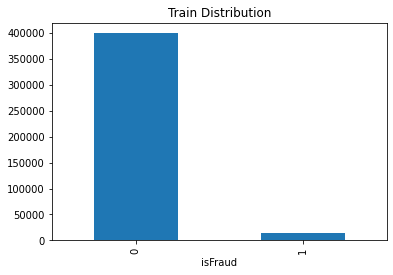

In [ ]:
#we can now ensure the minority class distribution appears similar in the training and testing datasets

train_data.pivot_table(index = 'isFraud', aggfunc = 'size').plot(kind='bar', title = 'Train Distribution')

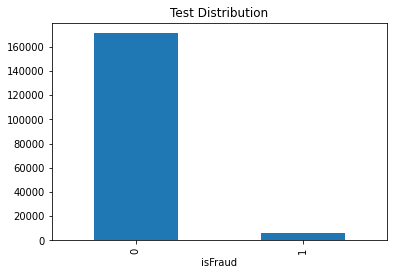

In [ ]:
test_data.pivot_table(index = 'isFraud', aggfunc ='size').plot(kind = 'bar', title = 'Test Distribution')

####**Minority Class Augmentation & Dataset Exporting**

There are a number of approaches to handling class imbalances in datasets, ranging in complexity. Two common methods for augmenting minority classes are adjusting data sampling, by selectively oversampling the minority class or undersampling the majority class, and imputing novel data points, often through synthetic data generation techniques such as nearest neighbor algorithms. The methods used in this project are briefly detailed below.

*SMOTE* - Synthetic Minority Over-Sampling Technique, or SMOTE, is a sophisticated approach to minority class augmentation that creates synthetic data points similar to existing data points. SMOTE employs a nearest neighbors approach to generating synthetic data points, by which neighbors close in feature space to existing minority class observations are generated. While a more advanced class balancing technique, this approach relies on the assumption that minority class observations are close in feature space to one another.

*Random Oversampling* - Random Oversampling, or ROS, is a simpler approach to minority class augmentation that involves randomly sampling minority class observations to duplicate in the dataset, artificially balancing class weights across the dataset. This approach to handling class imbalances is particularly effective when minority class observations are not always close in feature space, meaning that synthetic data points generated through nearest neighbor algorithms may not accurately capture the salient features of minority class observations.

Given that the closeness in feature space of fraud instances may impact the effectiveness of our class balancing techniques, it is worth examining. Using Principal Component Analysis (PCA), we are able to collapse our feature space down to 2-3 aggregate features, and examine the distribution of fraud instances across these features. If fraud instances are close in fetaure space, it is likely an indication that SMOTE will be a more effective method for class balancing.

Reference Link: https://trenton3983.github.io/files/projects/2019-07-19_fraud_detection_python/2019-07-19_fraud_detection_python.html

#####PCA & Feature Space Evaluation

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca_fit = pca.fit_transform(train_data.loc[:, train_data.columns.drop('TransactionDT_mmscaler', 'isFraud')].values) #excluding datetime and class labels

In [ ]:
train_data['PCA One'] = pca_fit[:, 0]
train_data['PCA Two'] = pca_fit[:, 1]
train_data['PCA Three'] = pca_fit[:, 2]

print('Variance explained by component 1: {}'.format(pca.explained_variance_ratio_[0]))
print('Variance explained by component 2: {}'.format(pca.explained_variance_ratio_[1]))
print('Variance explained by component 3: {}'.format(pca.explained_variance_ratio_[2]))

Variance explained by component 1: 0.6419405505745611
Variance explained by component 2: 0.2169166377631032
Variance explained by component 3: 0.07237235773141588


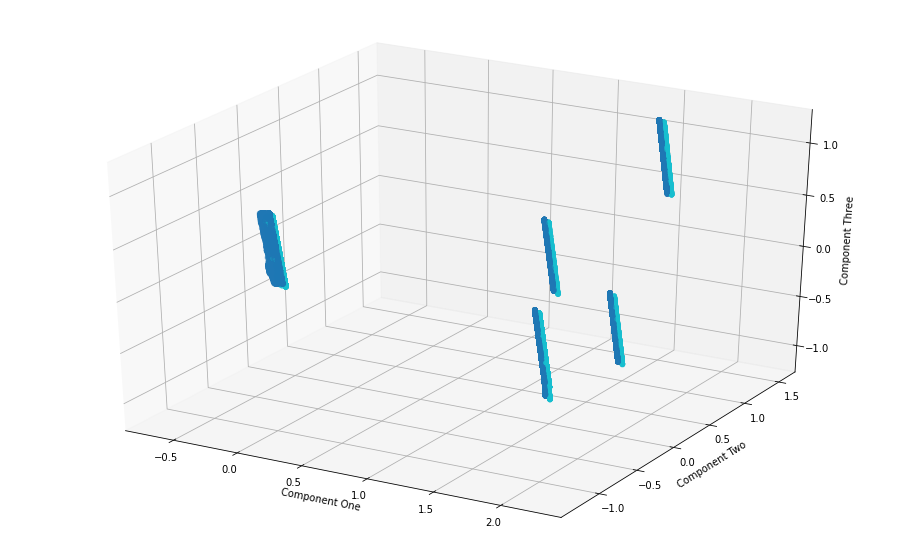

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(xs = train_data["PCA One"], 
           ys = train_data["PCA Two"], 
           zs = train_data["PCA Three"], 
           c = train_data["isFraud"],
           cmap = 'tab10')

ax.set_xlabel('Component One')
ax.set_ylabel('Component Two')
ax.set_zlabel('Component Three')

plt.show()

#Reference link: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b#:~:text=PCA%20is%20a%20technique%20for,the%20original%20data%20is%20distributed.

It appears that the instances of fraud within the dataset are relatively close in feature space based on the principal components generated. For this reason, I would expect that SMOTE will perform well as a method for minority class augmentation. For the sake of comparison, we can generate separate training data for our SMOTE and ROS methods to compare resulting model performance.

In [ ]:
train_data = train_data.drop(['PCA One', 'PCA Two', 'PCA Three'], axis = 1)

#####SMOTE

In [ ]:
#we can now move on to using SMOTE to balance our minority class distribution

from imblearn.over_sampling import SMOTE

columns = list(train_data.columns)
columns.remove('isFraud')
X_SMOTE, y_SMOTE = SMOTE().fit_resample(train_data[columns], train_data['isFraud'])

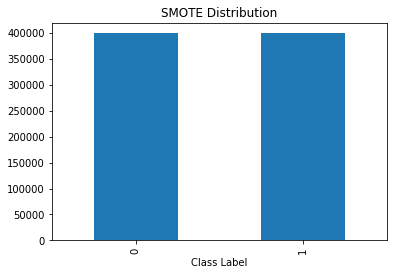

In [ ]:
pd.Series(y_SMOTE).value_counts().plot(kind = 'bar', title = 'SMOTE Distribution', xlabel = 'Class Label')

After verifying that we have appropriately balanced our class distributions, we can export our data to be used in our model training.

In [ ]:
#combining data for export

X_SMOTE['isFraud'] = y_SMOTE
X_SMOTE['isFraud'].value_counts()

0    398914
1    398914
Name: isFraud, dtype: int64

In [ ]:
#due to GitHub file size limitations discussed in the previous notebook, we'll need to partition our training dataset into smaller files

def split_dataframe(df, chunk_size): #split dataframe function used in previous notebook
    chunks = list()
    #num_chunks = len(df) // chunk_size + 1
    num_chunks = len(df) // chunk_size + (1 if len(df) % chunk_size else 0)
    for i in range(num_chunks):
        chunks.append(df[i * chunk_size: (i + 1) * chunk_size])
    return chunks

In [ ]:
length = len(X_SMOTE)
component_size = round((length) / 3) #file size was approximately 210 MB - so we'll split into 3 files

train_df1, train_df2, train_df3 = split_dataframe(X_SMOTE, component_size)

print(length)
print(len(train_df1) + len(train_df2) + len(train_df3))

797828
797828


In [ ]:
#exporting data to be uploaded via command line to our GitHub repository

from google.colab import files

df_list = [train_df1, train_df2, train_df3, test_data]

num = 1
for df in df_list:
  if num <= 3:
    df_name = 'SMOTE_train_data' + str(num) + '.csv'
  else:
    df_name = 'test_data.csv'
  df.to_csv(df_name, encoding = 'utf-8-sig')
  files.download(df_name)
  num += 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#####Random Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

y_train = train_data.pop('isFraud') 

oversampler = RandomOverSampler(random_state = 4)
X_ROS, y_ROS = oversampler.fit_resample(train_data, y_train)

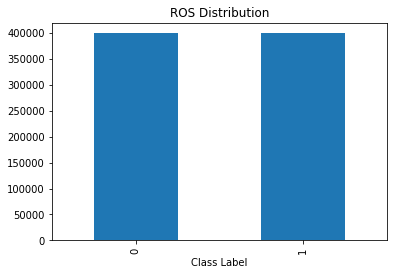

In [ ]:
pd.Series(y_ROS).value_counts().plot(kind = 'bar', title = 'ROS Distribution', xlabel = 'Class Label')

In [ ]:
#combining data for export

X_ROS['isFraud'] = y_ROS
X_ROS['isFraud'].value_counts()

0    398914
1    398914
Name: isFraud, dtype: int64

In [ ]:
length = len(X_ROS)
component_size = round((length) / 3)

ROS_train_df1, ROS_train_df2, ROS_train_df3 = split_dataframe(X_ROS, component_size)

print(length)
print(len(ROS_train_df1) + len(ROS_train_df2) + len(ROS_train_df3))

797828
797828


In [ ]:
df_list = [ROS_train_df1, ROS_train_df2, ROS_train_df3]

num = 1
for df in df_list:
  df_name = 'ROS_train_data' + str(num) + '.csv' #already exported testing data
  df.to_csv(df_name, encoding = 'utf-8-sig')
  files.download(df_name)
  num += 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>